In [2]:
import requests
import logging
from chessdotcom import get_player_stats, get_player_game_archives
import pprint
import pandas as pd
import re
from hashlib import md5

In [3]:
def get_game_archives(user_name):
    return f"https://api.chess.com/pub/player/{user_name}/games/archives"

def get_opening_eco(pgn):
    "Get ECO code of opening (encyclopedia of chess openings) """

    # FIXME some validity checks needed

    '\[ECO \"[A-Z][0-9][0-9]\"\] should match the codes like: [ECO "A20"] '

    match = re.search('\[ECO \"[A-Z][0-9][0-9]\"\]', pgn)
    if match:
        code = match.group(0)
        # strip useless characters
        code = code[6:-2]
        return code
    else:
        return ""

In [4]:
# setup pretty printer
printer = pprint.PrettyPrinter()

# get json file of player monthly game archives
user_name = "sddish"

# get data
monthly_archives = requests.get(get_game_archives(user_name)).json()


# preparing to turn into dataframe
game_url_hash, time_class, player_colour, opening, game_url, player_result, opponent_result, accuracy = [], [], [], [], [], [], [], []

# Each item in this list contains a URL, formatted like https://api.chess.com/pub/player/{user}/games/YYYY/MM
# Loop over each, and retrieve the games
for archive in monthly_archives["archives"]:
    # retrieve in json format, turn to pandas dataframe
    data = requests.get(archive).json()
    game_data = data["games"]
    #printer.pprint(games["games"][0])

    for game in game_data:

        # skip chess variants
        if game["rules"] != "chess":
            continue

        # check if user played as white or black
        user_colour = ""
        user_colour = "white" if game["white"]["username"] == user_name else "black"
        player_colour.append(user_colour)

        opponent_colour = "white" if player_colour == "black" else "black"

        time_class.append(game["time_class"])
        
        # player accuracy
        if "accuracies" in game.keys():
            accuracy.append(game["accuracies"][user_colour])
        else:
            accuracy.append(-999)

        # save player and opponent result, player "win" can be because opponent resigned, flagged, abandoned, etc
        player_result.append(game[user_colour]["result"])
        opponent_result.append(game[opponent_colour]["result"])

        opening_name = ""
        try:
            opening_name = get_opening_eco(game["pgn"])
            opening.append(opening_name)
        except KeyError:
            opening_name = "Unknown"

        url = game["url"]
        url_hash = md5(url.encode("utf-8")).hexdigest()

        game_url.append(url)
        game_url_hash.append(url_hash)

# save to dataframe
game_dict = {
    "url_hash"        : game_url_hash,
    "time_class"      : time_class,
    "player_colour"   : player_colour,
    "opening"         : opening,
    "game_url"        : game_url,
    "player_result"   : player_result,
    "opponent_result" : opponent_result,
    "player_accuracy" : accuracy
}

game_df = pd.DataFrame(game_dict,
        columns = [
            "url_hash",
            "time_class",
            "player_colour",
            "opening",
            "game_url",
            "player_result",
            "opponent_result",
            "player_accuracy"
          ]
      )

game_df.head(15)

,url_hash,time_class,player_colour,opening,game_url,player_result,opponent_result,player_accuracy
0,1a2e7834bdcf3d99fff7adb27c95baf9,rapid,black,D00,https://www.chess.com/game/live/6082171176,resigned,resigned,-999.00
1,372f6d48e815d08af67818d4fe28c92b,rapid,white,C23,https://www.chess.com/game/live/6082189674,win,checkmated,52.35
2,6c2c726b56cb05f7cece8a7934bd8838,rapid,white,C23,https://www.chess.com/game/live/6082369037,win,checkmated,-999.00
3,a981e6b9146bf9ac9cba18511c633277,rapid,black,C21,https://www.chess.com/game/live/6083538404,win,win,-999.00
4,f134b0bbea1ef28c28570d3b7bcd7ec4,rapid,white,C42,https://www.chess.com/game/live/6083617596,checkmated,win,-999.00
5,cd689d523f9bf78e9f3cace6091eee98,rapid,white,B02,https://www.chess.com/game/live/6083721351,resigned,win,-999.00
6,71ec4bd24bc223ca52b985ddfc68d2d3,rapid,black,A40,https://www.chess.com/game/live/6083766143,stalemate,stalemate,-999.00
7,7f9714e5d80f77611ea746b88b27c8b9,rapid,black,C20,https://www.chess.com/game/live/6083894206,checkmated,checkmated,-999.00
8,c9cc05308879fd263aae7219d620e811,rapid,black,C25,https://www.chess.com/game/live/6083898297,win,win,-999.00
9,5e764ef79a183f4dc0276be46fc6b4d8,rapid,black,C20,https://www.chess.com/game/live/6083923964,win,win,-999.00


In [5]:
# drop rows where accuracy is not available
df_with_accuracy = game_df[game_df["player_accuracy"] >= 0]

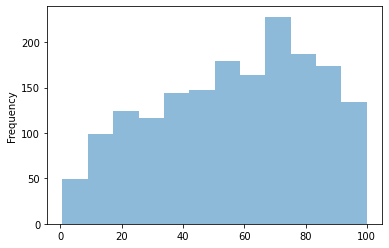

In [6]:
df_with_accuracy.player_accuracy.plot.hist(bins=12, alpha=0.5)

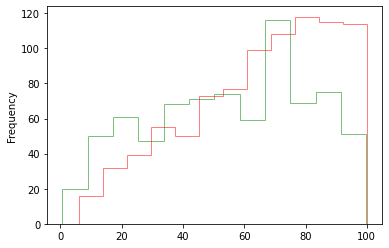

In [7]:
# kinda wish you could separate out my losses by flagging and checkmate. When I won by flagging, did I actually have a good position?
df_with_accuracy[df_with_accuracy["player_result"] == "win"].player_accuracy.plot.hist(bins=12, alpha=0.5, color="r", histtype='step')
df_with_accuracy[df_with_accuracy["opponent_result"] == "win"].player_accuracy.plot.hist(bins=12, alpha=0.5, color="g", histtype='step')

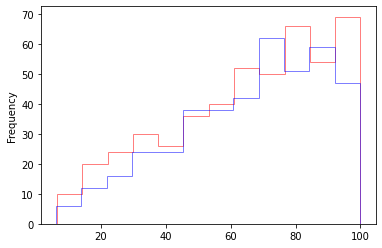

In [8]:
df_with_accuracy[(df_with_accuracy["player_result"] == "win") & (df_with_accuracy["player_colour"] == "white")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="r", histtype='step')
df_with_accuracy[(df_with_accuracy["player_result"] == "win") & (df_with_accuracy["player_colour"] == "black")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="b", histtype='step')

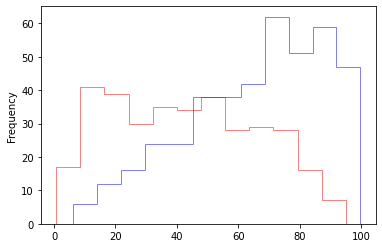

In [9]:
df_with_accuracy[(df_with_accuracy["opponent_result"] == "win") & (df_with_accuracy["player_colour"] == "white")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="r", histtype='step')
df_with_accuracy[(df_with_accuracy["opponent_result"] == "win") & (df_with_accuracy["player_colour"] == "black")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="b", histtype='step')

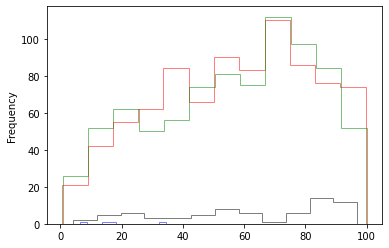

In [12]:
df_with_accuracy[(df_with_accuracy["time_class"] == "rapid")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="red", histtype='step', label="rapid")
df_with_accuracy[(df_with_accuracy["time_class"] == "blitz")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="green", histtype='step', label="blitz")
df_with_accuracy[(df_with_accuracy["time_class"] == "bullet")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="blue", histtype='step', label="bullet")
df_with_accuracy[(df_with_accuracy["time_class"] == "daily")].player_accuracy.plot.hist(bins=12, alpha=0.5, color="black", histtype='step', label="daily")